In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import glob
import datetime as dt
import statsmodels.api as sm

In [3]:
#os_path = os.getcwd()
energy_df = pd.read_pickle('sofiaweather.pkl')

In [4]:
energy_df

day
2015-01-01   -9.7
2015-01-02   -6.2
2015-01-03    0.2
2015-01-04    0.2
2015-01-05   -1.7
             ... 
2021-01-22    3.4
2021-01-23    5.9
2021-01-24    7.9
2021-01-25    4.8
2021-01-26    5.0
Name: София, Length: 2218, dtype: float64

In [5]:
energy_df = pd.DataFrame(energy_df)
energy_df.head()

,София
day,
2015-01-01,-9.7
2015-01-02,-6.2
2015-01-03,0.2
2015-01-04,0.2
2015-01-05,-1.7


In [7]:
energy_df.index = pd.to_datetime(energy_df.index)

#aggregate to daily 
energy_df = energy_df.groupby(energy_df.index.strftime('%Y-%m-%d')).mean()
#energy_df.index = pd.to_datetime(energy_df.index)
#energy_df = energy_df.loc[energy_df.index<'2020-01-01']
energy_df.head()

,София
day,
2015-01-01,-9.7
2015-01-02,-6.2
2015-01-03,0.2
2015-01-04,0.2
2015-01-05,-1.7


# EDA

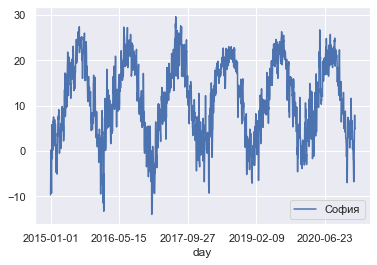

In [8]:
energy_df.plot();

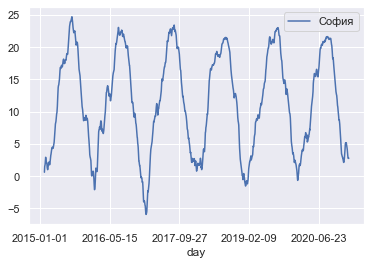

In [9]:
energy_df.rolling(30).mean().plot();

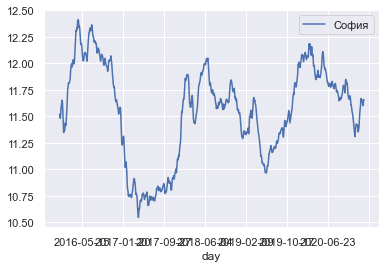

In [10]:
energy_df.rolling(365).mean().plot();

In [12]:
energy_df['София'] = pd.to_numeric(energy_df['София'])
sns.kdeplot(energy_df);

ValueError: If using all scalar values, you must pass an index

In [13]:
dfnew = pd.DataFrame(energy_df.copy())
dfnew['Month'] = energy_df.index.month
dfnew['Day of the week'] = energy_df.index.weekday

dfnew = pd.pivot_table(dfnew, values='Load', index=['Month'],
                     columns=['Day of the week'], aggfunc=np.mean, fill_value=0)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(dfnew);

AttributeError: 'Index' object has no attribute 'month'

# Time Series Stationarity

 - Weak vs Strict Stationarity 
 - Weak stationarity implies:
  - 1st moment is constant over time
  - autocovariance is constant over time
  - 2nd moment is finite
 - Strict stationarity implies:
  - the unconditional joint probability distribution does not change over time
  
  Strict stationarity does not imply weak stationarity and vice versa.
  

## Trend vs Difference Stationarity
## Stationarity Tests

 - ADF test: $H_0$ = there is a unit root vs $H_\alpha$ = there isn't; different types of ADF:
  - no constant (drift) or trend in the OLS regression
  - constant (drift) in the OLS regression
  - constant (drift) and linear/quadratic trend
  - http://faculty.smu.edu/tfomby/eco6375/BJ%20Notes/ADF%20Notes.pdf
 - KPSS test:$H_0$ = the series is trend-stationary vs $H_\alpha$ = the series has a unit root

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adf_test(series, crit='BIC'):
    print_tests = 'Stationarity tests \n \
    P-values for: ADF with drift: {0:0.3f}, ADF drift and trend: {1:0.3f}, ADF no drift or trend: {2:0.3f} \n \
    KPSS p-value: {3:0.3f}'
    adftest_c = adfuller(series, autolag='BIC', regression = 'c')
    adftest_ct = adfuller(series, autolag='BIC', regression = 'ct')
    adftest_nc = adfuller(series, autolag='BIC', regression = 'nc')
    kpsstest = kpss(energy_df)

    return print(print_tests.format(adftest_c[1], adftest_ct[1], adftest_nc[1], kpsstest[1]))
    
adf_test(energy_df)

Stationarity tests 
     P-values for: ADF with drift: 0.025, ADF drift and trend: 0.105, ADF no drift or trend: 0.086 
     KPSS p-value: 0.100


C:\Users\GerganaMarkova\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\GerganaMarkova\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# Autocorrelation and partial autocorrelation functions (ACF and PACF)


### Rule of thumb for 'guessing' lag orders of an ARMA process
|  | ACF | PACF |
| --- | --- | --- |
| AR(p) process| slowly decaying | p lags |
| MA(q) process | q lags | slowly decaying |
| ARMA(p, q) process | slowly decaying | slowly decaying |

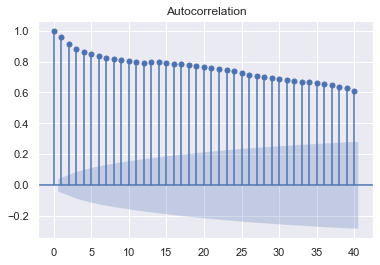

In [15]:
sm.graphics.tsa.plot_acf(energy_df, lags=40)
plt.show()

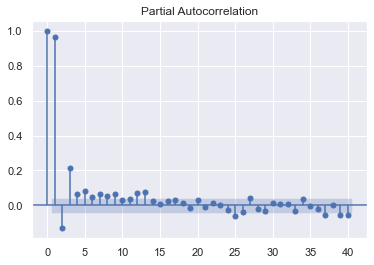

In [16]:
sm.graphics.tsa.plot_pacf(energy_df, lags=40)
plt.show()

# Seasonal Decomposition

## Seasonal Decomposition using moving average
statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
- Additive 
- Multiplicative

## Unobserved components model
https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_seasonal.html

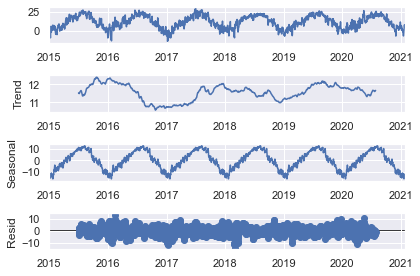

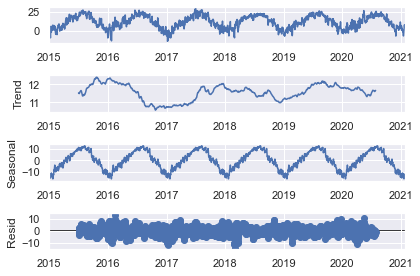

In [17]:
energy_df = energy_df.asfreq('d')
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(energy_df, model='additive', period = 365)
result.plot()

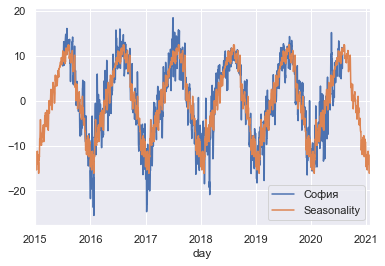

In [18]:
graph = pd.DataFrame(energy_df - energy_df.rolling(365, center=True).mean())
graph['Seasonality'] = result.seasonal
graph.plot();

KeyboardInterrupt: 

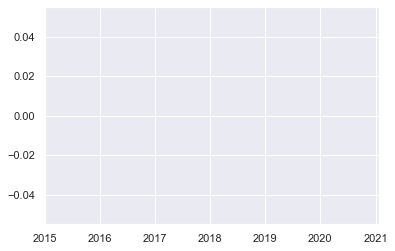

In [20]:
decomp_df = energy_df - result.seasonal
decomp_df.plot();

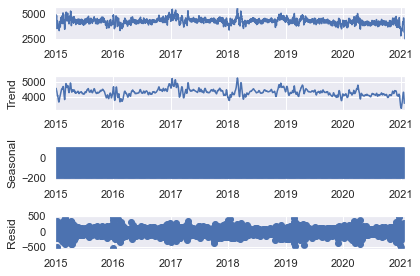

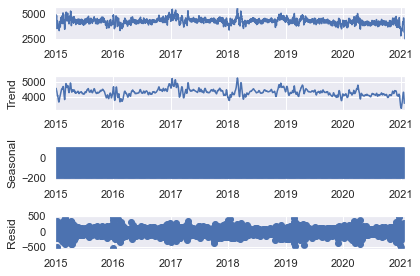

In [16]:
result = seasonal_decompose(decomp_df, model='additive', period = 7)
result.plot()

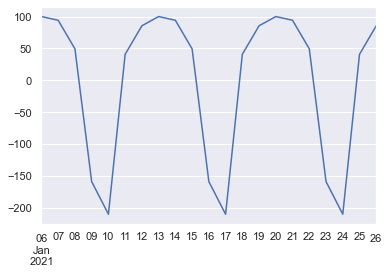

In [17]:
result.seasonal.iloc[-21:].plot();

In [18]:
decomp_df = decomp_df - result.seasonal

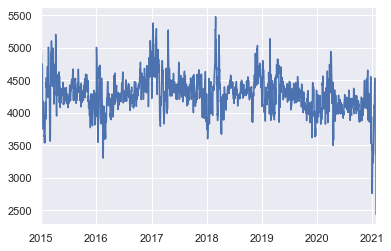

In [19]:
decomp_df.plot();

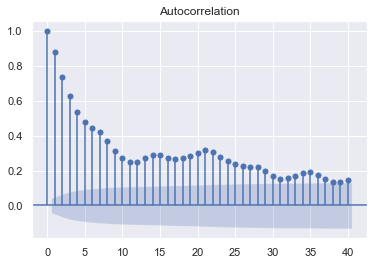

In [20]:
sm.graphics.tsa.plot_acf(decomp_df, lags=40)
plt.show()

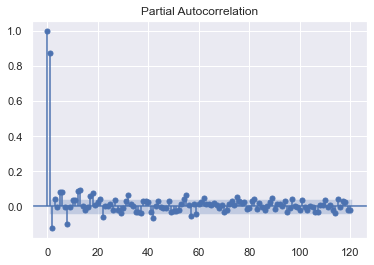

In [21]:
sm.graphics.tsa.plot_pacf(decomp_df, lags=120)
plt.show()

# Distributional transformations

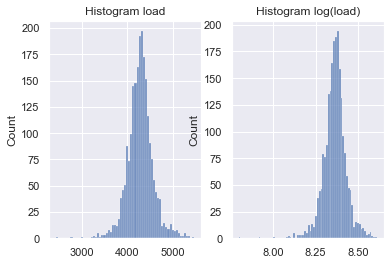

In [22]:
fig, axes = plt.subplots(1, 2)

sns.histplot(decomp_df, ax = axes[0]);
axes[0].set_title('Histogram load')

sns.histplot(np.log(decomp_df), ax = axes[1]);
axes[1].set_title('Histogram log(load)');

# ARIMA (p, d, q) models 

## Wald's Decomposition
Every weakly stationary, purely nondeterministic, stochastic process $x-\mu$ can be expressed as a linear combination of a sequence of random variables:
$x-\mu = a_t+\psi_1a_{t-1} + ... = \sum_{j = 0}^{\infty}\psi_j a_{t-j}$, where $a_t \sim WN(0, \sigma^2)$


- AR(p) models can be estimated by OLS (efficient estimator)
- ARMA(p, q) models are estimated using MLE, as the MA(q) process is not directly observed in the data
- ARMA can be used only on stationary, invertible and causal stochastic processes
- if the series is I(d), or integrated of order d, we can use the ARIMA(p, d, q) model

## Diagnostics checking
- observing the residuals from the fitted model for misspecifications such as
 - autocorrelated residuals (SACF)
 - overfit the model by including p+1/q+1 lags in order to check if they are significant

## Information criteria
- AIC: $AIC(p, q) = log\hat{\sigma}^2 + 2(p+q)T^{-1}$
- BIC: $BIC(p, q) = log\hat{\sigma}^2 + (p+q)T^{-1}logT$
- BIC is *strongly consistent*, or in other words chooses the 'true' model asymptotically, whereas AIC will choose an over-parametrized model (might be better for forecasting)

In [33]:
from statsmodels.tsa.ar_model import AutoReg
out = 'AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}'
res = AutoReg(decomp_df.dropna(), lags = 29, seasonal=False).fit()
print(out.format(res.aic, res.hqic, res.bic))

AIC: 9.649, HQIC: 9.678, BIC: 9.729


C:\Users\GerganaMarkova\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [34]:
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 2218
Model:                    AutoReg(29)   Log Likelihood              -13635.666
Method:               Conditional MLE   S.D. of innovations            122.761
Date:                Mon, 01 Feb 2021   AIC                              9.649
Time:                        12:43:05   BIC                              9.729
Sample:                    01-30-2015   HQIC                             9.678
                         - 01-26-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    270.0077     62.796      4.300      0.000     146.929     393.086
y.L1           1.0482      0.022     48.122      0.000       1.006       1.091
y.L2          -0.2419      0.032     -7.668      0.0

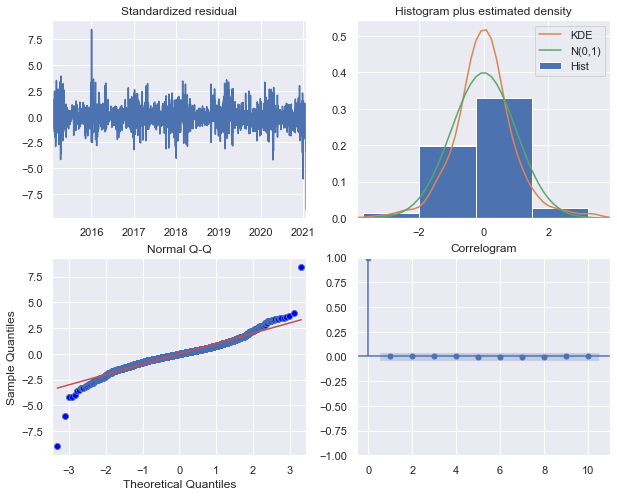

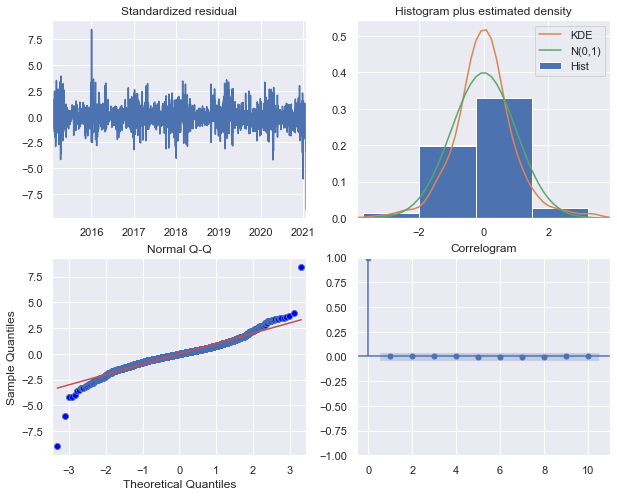

In [35]:
res.plot_diagnostics(figsize = (10, 8))

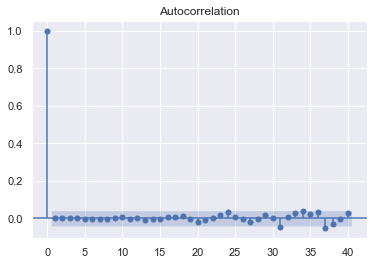

In [36]:
residuals = res.resid

sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

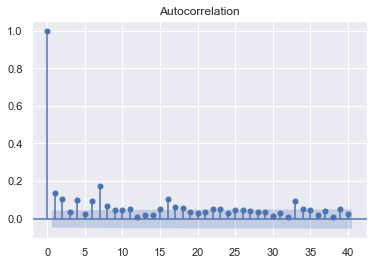

In [257]:
sm.graphics.tsa.plot_acf(residuals**2, lags=40)
plt.show()

In [28]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [30]:
from pmdarima.arima import KPSSTest
adftest = KPSSTest(alpha = 0.05)
adftest.should_diff(energy_df)

(0.1, False)

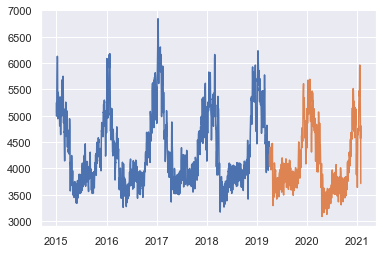

In [34]:
train, test = train_test_split(energy_df, train_size=int(0.7*len(energy_df)))
plt.plot(train)
plt.plot(test);

In [35]:
model = pm.auto_arima(train, start_p = 0, d = 1, start_q = 0, 
                      max_p = 10, max_d = 2, max_q = 20, information_criterion='aic',
                      test = 'adf', max_P=2, max_D=1, max_Q=3, max_order=5, m=2, seasonal=True)


In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1552
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 2)   Log Likelihood              -10252.168
Date:                                Fri, 29 Jan 2021   AIC                          20516.335
Time:                                        11:23:39   BIC                          20548.415
Sample:                                             0   HQIC                         20528.266
                                               - 1552                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1461      0.023      6.491      0.000       0.102       0.190
ar.S.L2       -0.5767      0.067     -8.591      0.000      -0.708      -0.445
ar.S.L4        0.1850      0.067      2.777      0.005       0.054       0.316
ma.S.L2        0.3265      0.061      5.337      0.000       0.207       0.446
ma.S.L4       -0.5136      0.060     -8.604      0.000      -0.631      -0.397
sigma2      3.227e+04    893.732     36.102      0.000    3.05e+04     3.4e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               146.54
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
forecast = pd.DataFrame(model.predict(n_periods = len(test)), index = test.index)
forecast.columns = ['Forecast']

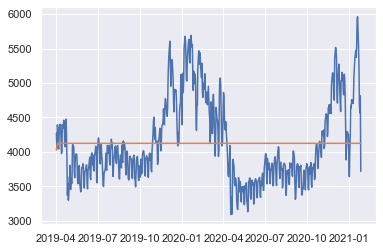

In [38]:
plt.plot(test, label='test')
plt.plot(forecast, label='forecast');

In [308]:
forecast

,Forecast
0,3571.869609
1,3591.704980
2,3639.762773
3,3689.748063
4,3681.438595
...,...
543,3679.197790
544,3679.197790
545,3679.197790
546,3679.197790


In [96]:
train, test = train_test_split(energy_df, train_size=int(0.7*len(decomp_df)))
# Fit your model
model = pm.auto_arima(train, seasonal = False)
# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
#x = np.arange(decomp_df.shape[0])
#plt.plot(x[:len(train)], train, c='blue')
#plt.plot(x[len(train):], forecasts, c='green')
#plt.show()

In [ ]:
model.summary()

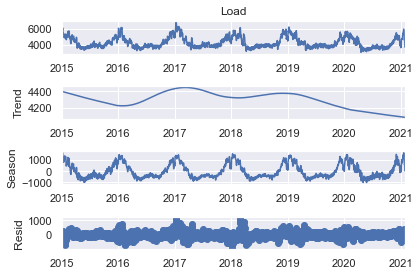

In [114]:
from statsmodels.tsa.seasonal import STL
res = STL(energy_df, period = 365).fit()
res.plot()
plt.show()

<AxesSubplot:>

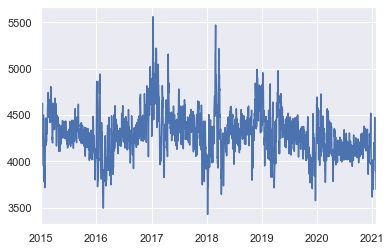

In [117]:
df1 = energy_df - res.seasonal
df1.plot()

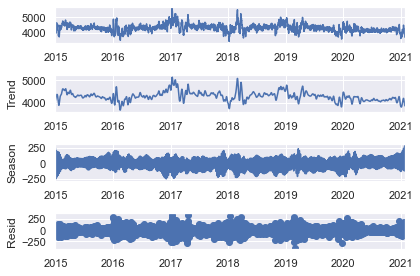

In [118]:
res = STL(df1, period = 7).fit()
res.plot()
plt.show()

In [121]:
df1 = df1- res.seasonal

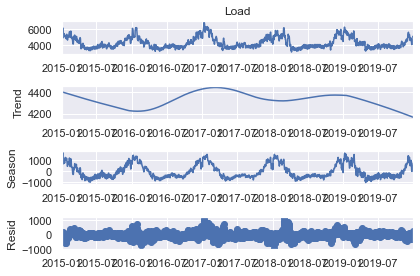

In [258]:
from statsmodels.tsa.seasonal import STL
stl = STL(energy_df, period=365)
res = stl.fit()
fig = res.plot()

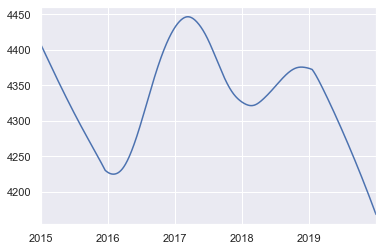

In [259]:
res.trend.plot();

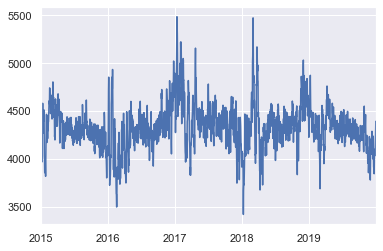

In [261]:
decomp_df1 = energy_df - res.seasonal
decomp_df1.plot();